In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython import display
import sys
import os
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.utils 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import random
import dlib
import glob
from skimage import io
from skimage.draw import circle
from skimage.io import imread_collection
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import matplotlib.image as mpimg

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
FAST_RUN = False
IMAGE_WIDTH=30
IMAGE_HEIGHT=140
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
filenames = os.listdir("/content/drive/MyDrive/Colab_Notebooks/DataSet/Eyes/TrainingSet")
categories = []
for filename in filenames:
    category = filename.split(' ')[0]
    if category == 'Foucsed':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,UnFoucsed 501.jpg,0
1,UnFoucsed 502.jpg,0
2,UnFoucsed 503.jpg,0
3,UnFoucsed 504.jpg,0
4,UnFoucsed 505.jpg,0


In [6]:
df.tail()

,filename,category
2994,Foucsed 995.jpg,1
2995,Foucsed 996.jpg,1
2996,Foucsed 997.jpg,1
2997,Foucsed 998.jpg,1
2998,Foucsed 999.jpg,1


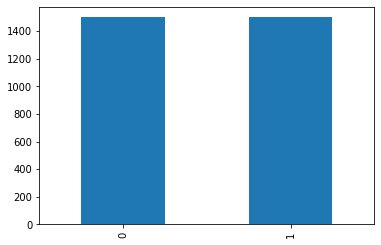

In [7]:
df['category'].value_counts().plot.bar()

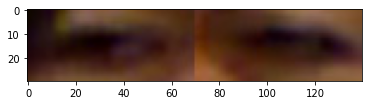

In [8]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Colab_Notebooks/DataSet/Eyes/TrainingSet/"+sample)
plt.imshow(image)

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 138, 32)       896       
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 28, 138, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 69, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 69, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 67, 64)        18496     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 12, 67, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 33, 64)         0

In [10]:
earlystop = EarlyStopping(patience=10)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

In [13]:
df["category"] = df["category"].replace({0: 'UnFoucsed', 1: 'Foucsed'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


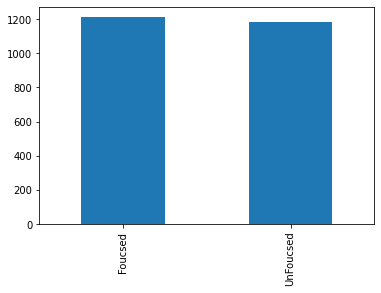

In [15]:
train_df['category'].value_counts().plot.bar()

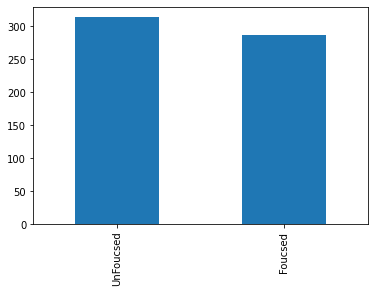

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/Colab_Notebooks/DataSet/Eyes/TrainingSet/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2399 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/Colab_Notebooks/DataSet/Eyes/TrainingSet/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 600 validated image filenames belonging to 2 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/Colab_Notebooks/DataSet/Eyes/TrainingSet/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


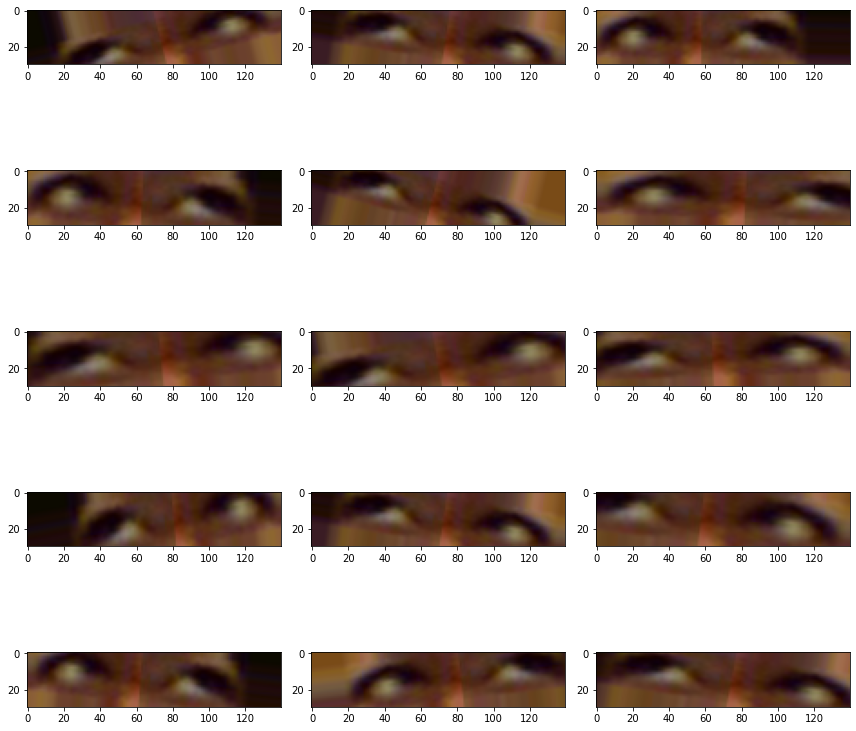

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [22]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
159/159 [==============================] - 528s 3s/step - loss: 0.7037 - accuracy: 0.7924 - val_loss: 8.0769 - val_accuracy: 0.4767
Epoch 2/50
159/159 [==============================] - 30s 187ms/step - loss: 0.4989 - accuracy: 0.8163 - val_loss: 2.4799 - val_accuracy: 0.4733
Epoch 3/50
159/159 [==============================] - 30s 187ms/step - loss: 0.4206 - accuracy: 0.8268 - val_loss: 0.3638 - val_accuracy: 0.8400
Epoch 4/50
159/159 [==============================] - 30s 187ms/step - loss: 0.3713 - accuracy: 0.8482 - val_loss: 0.8678 - val_accuracy: 0.5733
Epoch 5/50
159/159 [==============================] - 30s 187ms/step - loss: 0.3101 - accuracy: 0.8612 - val_loss: 0.4828 - val_accuracy: 0.8650
Epoch 6/50
159/159 [==============================] - 30s 186ms/step - loss: 0.2750 - accuracy: 0.8809 - val_loss: 0.4137 - val_accuracy: 0.7800
Epoch 7/50
159/159 [==============================] - 30s 188ms/step - loss: 0.2968 - accuracy: 0.8758 - val_loss: 0.2807 - val_accu

In [23]:
model.save_weights("model.h5")

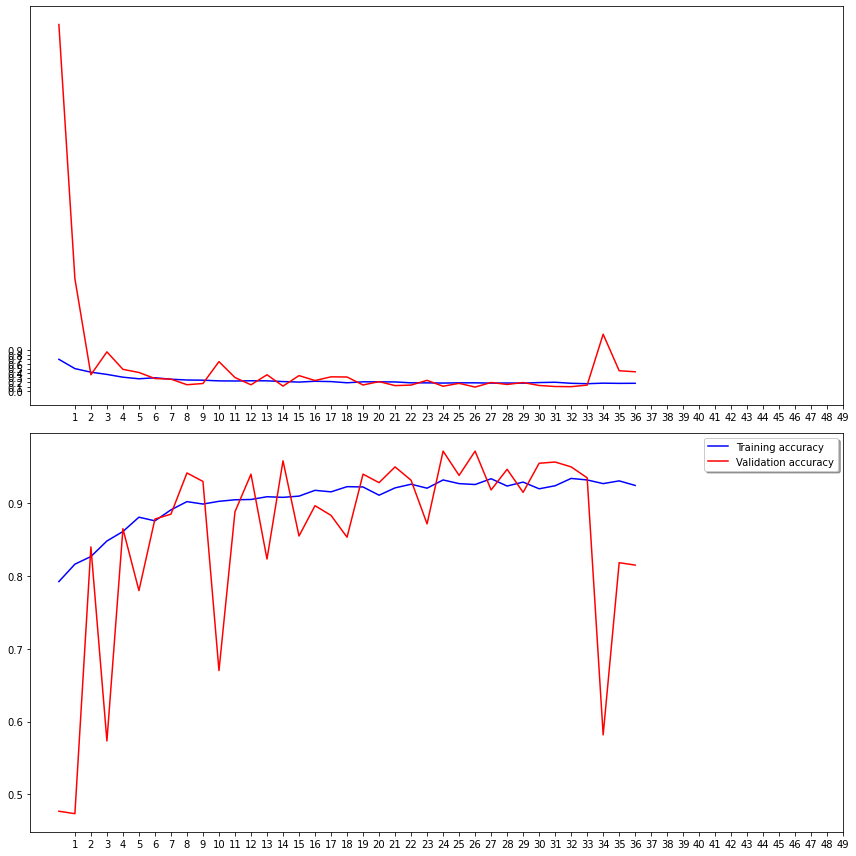

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [25]:
test_filenames = os.listdir("/content/drive/MyDrive/Colab_Notebooks/DataSet/Eyes/Test_imgs")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/Colab_Notebooks/DataSet/Eyes/Test_imgs", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 998 validated image filenames.


In [27]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [28]:
test_df['category'] = np.argmax(predict, axis=-1)

In [29]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [30]:
test_df['category'] = test_df['category'].replace({ 'Foucsed': 1, 'UnFoucsed': 0 })

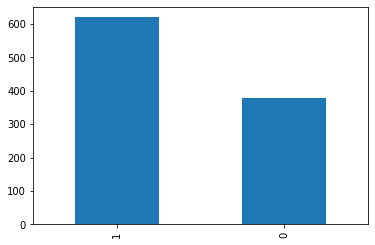

In [31]:
test_df['category'].value_counts().plot.bar()

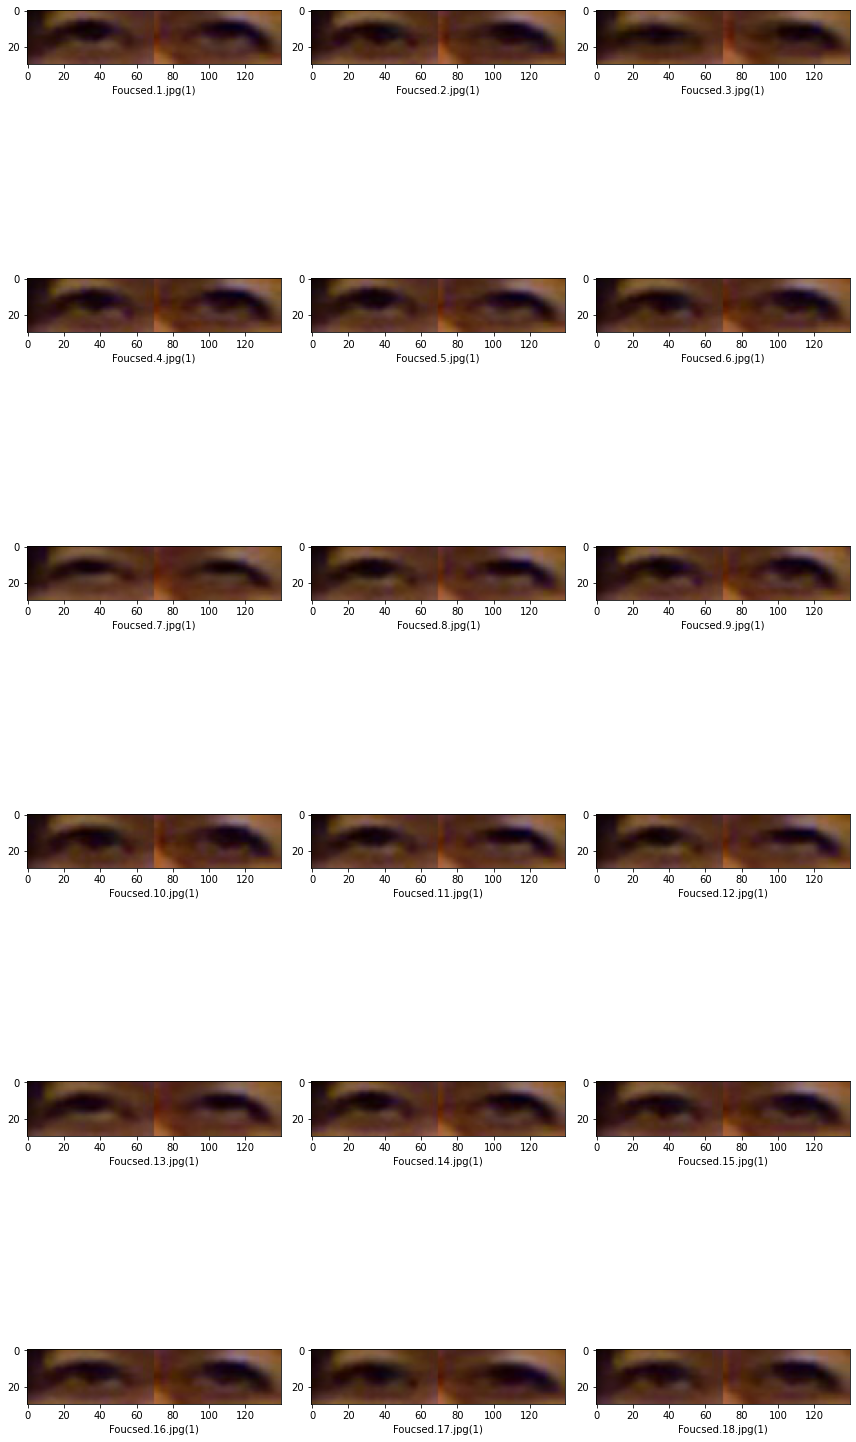

In [32]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/Colab_Notebooks/DataSet/Eyes/Test_imgs/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [33]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [34]:
# dlib face landmarks detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Colab_Notebooks/shape_predictor_68_face_landmarks.dat')

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

# extract land marks
def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        #raise TooManyFaces
        return np.matrix([0,0])
    if len(rects) == 0:
        #raise NoFaces
        return np.matrix([0,0])

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])


class GetEyes():
    def __init__(self, img):
        self.img = img.copy()
        landmarks = self.get_landmarks(frame)
        self.left_eye_lms = landmarks[42:47]
        self.right_eye_lms = landmarks[36:41]
        self.left_eye_rect = self.get_rect(self.left_eye_lms)
        self.right_eye_rect = self.get_rect(self.right_eye_lms)

    @staticmethod
    def get_landmarks(im):
        # extract land marks representing the eyes
        rects = detector(im, 1)

        if len(rects) > 1:
          raise TooManyFaces
        if len(rects) == 0:
          raise NoFaces

        return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])
    
    @classmethod
    def get_rect(self, landmarks):
        # get rect from eye landmarks
        border = 5
        l_ul_x = min(landmarks[:,0])
        l_ul_y = min(landmarks[:,1])
        l_lr_x = max(landmarks[:,0])
        l_lr_y = max(landmarks[:,1])
        pt1 = (np.sum(l_ul_x)-border, np.sum(l_ul_y)-border)
        pt2 = (np.sum(l_lr_x)+border, np.sum(l_lr_y)+border)
        return [pt1, pt2]
    
    def draw(self):
        # draw rect
        eimg = self.img
        eimg = cv2.rectangle(img, self.right_eye_rect[0], self.right_eye_rect[1], (255, 0, 0),thickness=3) 
        eimg = cv2.rectangle(img, self.left_eye_rect[0], self.left_eye_rect[1], (255, 0, 0),thickness=3) 
        plt.imshow(eimg)
        return eimg
    
    def crop_right_eye(self):
        # crop out right eye
        return self.img[self.right_eye_rect[0][1]:self.right_eye_rect[1][1], self.right_eye_rect[0][0]:self.right_eye_rect[1][0]]
    
    def crop_left_eye(self):
        # crop out left eye
        return self.img[self.left_eye_rect[0][1]:self.left_eye_rect[1][1], self.left_eye_rect[0][0]:self.left_eye_rect[1][0]]


In [ ]:
img = frame.copy()
eyes = GetEyes(img)
plt.imshow(eyes.draw())

NameError: ignored

In [ ]:
def preprocess(img):
    # preprocess eye images
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #img = cv2.GaussianBlur(img,(3, 3),0);
    img = cv2.medianBlur(img, 5)
    windowClose = np.ones((5,5),np.uint8)
    windowOpen = np.ones((3,3),np.uint8)
    windowErode = np.ones((3,3),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, windowClose)
    #img = cv2.morphologyEx(img, cv2.MORPH_ERODE, windowErode)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, windowOpen)
    #plt.imshow(img)
    return img
    
def detect_pupil(img):
    output = img.copy()
    if len(img.shape)==3:
        # use red channel because of human comlexion
        img = preprocess(img[:,:,0])
    # detect circles in the image
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, int(img.shape[1]/3),200,100,8,8)
    
    # ensure at least some circles were found
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # draw the circle in the output image, then draw a rectangle
            # corresponding to the center of the circle
            cv2.circle(output, (x, y), r, (255, 255, 255), 1)
            cv2.rectangle(output, (x - 2, y - 2), (x + 2, y + 2), (255, 0, 0), 1)
    return circles, output

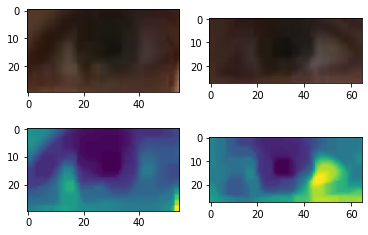

In [ ]:
eye_img_r = eyes.crop_right_eye()
eye_img_l = eyes.crop_left_eye()
proc_r = preprocess(eye_img_r)
proc_l = preprocess(eye_img_l)

# display right and left eye image
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(eye_img_r)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(eye_img_l)
ax1 = fig.add_subplot(2,2,3)
ax1.imshow(proc_r)
ax2 = fig.add_subplot(2,2,4)
ax2.imshow(proc_l)

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Colab_Notebooks/Graduation_Project.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.upload(<filename>)

SyntaxError: ignored